# First preliminary analysis of the same plate cell painting data


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import fastcluster  
from sklearn.preprocessing import StandardScaler
import polars as pl

In [ ]:
## download and concatenate the raw data from the two plates


plate1 = pd.read_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/BR00145692_augmented.csv")


plate2 = pd.read_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/BR00145695_augmented.csv")


df_combined = pd.concat([plate1, plate2], ignore_index=True)

df_combined.to_parquet("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/raw.parquet", index=False)


In [ ]:
## load the raw data
raw_data = pl.read_parquet("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/raw.parquet")
raw_data = raw_data.to_pandas()

In [ ]:
raw_data

,Metadata_plate_map_name,Metadata_source_plate,Metadata_source_well_position,Metadata_destination_plate,Metadata_BROAD_ID,Metadata_assay_conc_uM,Metadata_Source,Metadata_Vendor Catalog ID,Metadata_Compound Name,Metadata_Annotation,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,BR00145692,Plate1,A01,Dest1,BRD-K21728777-001-03-9,5.1,MedChemExpress,HY-13253,AMG 900,JUMP control,...,80.543,85.097,80.038,78.890,79.850,79.036,78.935,78.973,78.601,79.159
1,BR00145692,Plate1,A02,Dest1,DMSO,0.0,None,None,None,None,...,108.730,114.340,108.040,106.430,108.170,106.470,106.040,106.830,106.220,106.530
2,BR00145692,Plate1,A03,Dest1,EMPTY,0.0,None,None,None,None,...,105.030,111.800,104.750,103.040,104.920,103.590,102.810,103.310,102.850,103.570
3,BR00145692,Plate1,A04,Dest1,EMPTY,0.0,None,None,None,None,...,85.732,93.604,85.008,83.567,85.025,83.764,83.525,83.907,83.272,83.865
4,BR00145692,Plate1,A05,Dest1,EMPTY,0.0,None,None,None,None,...,79.294,85.062,78.536,77.294,78.764,77.527,77.016,77.334,77.237,77.795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,BR00145695,Plate1,P20,Dest1,EMPTY,0.0,None,None,None,None,...,110.300,115.300,109.350,108.010,109.250,108.060,107.870,108.460,107.800,108.480
764,BR00145695,Plate1,P21,Dest1,EMPTY,0.0,None,None,None,None,...,95.015,101.910,93.770,92.734,93.782,92.855,92.694,93.230,92.578,93.573
765,BR00145695,Plate1,P22,Dest1,EMPTY,0.0,None,None,None,None,...,85.765,92.267,85.033,83.814,84.742,83.671,83.739,84.084,83.515,84.374
766,BR00145695,Plate1,P23,Dest1,BRD-K91188791-001-18-3,5.1,Selleck,S7393,Aloxistatin,JUMP control,...,81.997,87.902,81.890,80.735,81.770,80.737,80.436,80.632,80.431,81.007


In [ ]:
## cell count plots of compound that have multiple concentrations

compounds_with_multiple_concentrations = raw_data.groupby('Metadata_Compound Name')['Metadata_assay_conc_uM'].nunique()
compounds_with_multiple_concentrations = compounds_with_multiple_concentrations[compounds_with_multiple_concentrations > 1].index


filtered_data = raw_data[raw_data['Metadata_Compound Name'].isin(compounds_with_multiple_concentrations)]

filtered_data['Replicate'] = filtered_data['Metadata_Plate'].apply(lambda x: 1 if x == 'BR00145692' else 2)


max_concentration = filtered_data.groupby('Metadata_Compound Name')['Metadata_assay_conc_uM'].max()

compounds_max_300 = max_concentration[max_concentration == 300].index
compounds_max_100 = max_concentration[(max_concentration >= 40) & (max_concentration <= 100)].index

compounds_max_50 = max_concentration[max_concentration <= 30].index

filtered_data_max_300 = filtered_data[filtered_data['Metadata_Compound Name'].isin(compounds_max_300)]
filtered_data_max_100 = filtered_data[filtered_data['Metadata_Compound Name'].isin(compounds_max_100)]
filtered_data_max_50 = filtered_data[filtered_data['Metadata_Compound Name'].isin(compounds_max_50)]


g_300 = sns.FacetGrid(filtered_data_max_300, col="Metadata_Compound Name", hue="Replicate", col_wrap=4, height=5)
g_300.map(sns.lineplot, "Metadata_assay_conc_uM", "Metadata_Count_Cells", marker="o")
g_300.set_axis_labels("Concentration (µM)", "Numbre of cells")
g_300.set_titles("{col_name}")
g_300.add_legend(title="Plate")
plt.show()

g_100 = sns.FacetGrid(filtered_data_max_100, col="Metadata_Compound Name", hue="Replicate", col_wrap=4, height=5)
g_100.map(sns.lineplot, "Metadata_assay_conc_uM", "Metadata_Count_Cells", marker="o")
g_100.set_axis_labels("Concentration (µM)", "Numbre of cells")
g_100.set_titles("{col_name}")
g_100.add_legend(title="Plate")
plt.show()

g_50 = sns.FacetGrid(filtered_data_max_50, col="Metadata_Compound Name", hue="Replicate", col_wrap=4, height=5)
g_50.map(sns.lineplot, "Metadata_assay_conc_uM", "Metadata_Count_Cells", marker="o")
g_50.set_axis_labels("Concentration (µM)", "Numbre of cells")
g_50.set_titles("{col_name}")
g_50.add_legend(title="Plate")
plt.show()


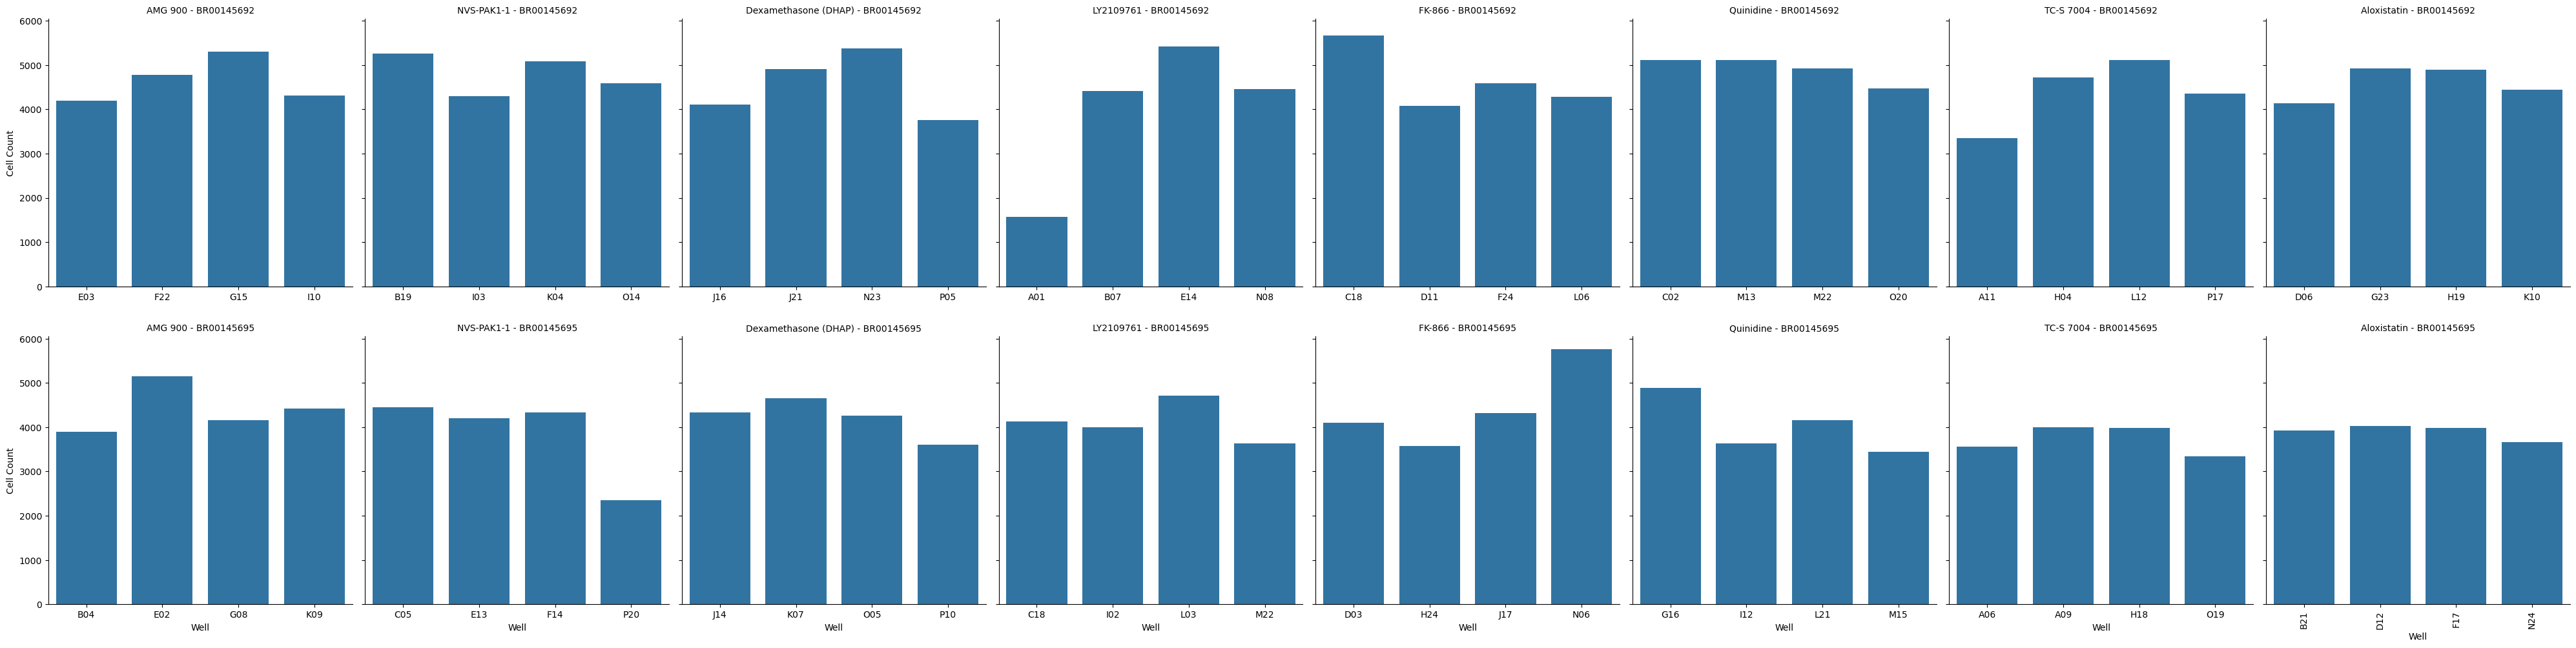

In [ ]:
## cell count plots of compound that have only one concentration

compound_counts = raw_data.groupby('Metadata_Compound Name')['Metadata_assay_conc_uM'].nunique()
single_concentration_compounds = compound_counts[compound_counts == 1].index
filtered_data_single_concentration = raw_data[raw_data['Metadata_Compound Name'].isin(single_concentration_compounds)]


g_single_concentration = sns.FacetGrid(
    filtered_data_single_concentration, 
    col="Metadata_Compound Name", 
    row="Metadata_Plate", 
    height=5, 
    sharex=False, 
    sharey=True  
)

def plot_bar(data, **kwargs):
    compound = data["Metadata_Compound Name"].iloc[0]  
    plate = data["Metadata_Plate"].iloc[0]  
    wells = sorted(data["Metadata_Well"].unique())  
    sns.barplot(x="Metadata_Well", y="Metadata_Count_Cells", data=data, order=wells, **kwargs)


g_single_concentration.map_dataframe(plot_bar)


g_single_concentration.set_axis_labels("Well", "Cell Count")
g_single_concentration.set_titles("{col_name} - {row_name}")

plt.xticks(rotation=90) 
plt.show()


## Normalized data

In [ ]:
## dowload and concatenate the normalized data

plate1 = pd.read_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/BR00145692_normalized_feature_select_batch.csv")


plate2 = pd.read_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/BR00145695_normalized_feature_select_batch.csv")


df_combined = pd.concat([plate1, plate2], ignore_index=True)

df_combined.to_parquet("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/normalized.parquet", index=False)


In [ ]:
## load the normalized data

norm_data = pl.read_parquet("../CP_data/normalized.parquet")
norm_data = norm_data.to_pandas()


In [ ]:
norm_data

,Metadata_plate_map_name,Metadata_source_plate,Metadata_source_well_position,Metadata_destination_plate,Metadata_BROAD_ID,Metadata_assay_conc_uM,Metadata_Source,Metadata_Vendor Catalog ID,Metadata_Compound Name,Metadata_Annotation,...,Nuclei_Texture_InfoMeas1_RNA_5_01_256,Nuclei_Texture_InfoMeas2_AGP_10_03_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_10_01_256,Nuclei_Texture_InfoMeas2_Mito_10_01_256,Nuclei_Texture_InfoMeas2_RNA_10_03_256,Nuclei_Texture_InverseDifferenceMoment_AGP_10_01_256,Nuclei_Texture_InverseDifferenceMoment_RNA_3_02_256,Nuclei_Texture_SumEntropy_Brightfield_10_01_256,Nuclei_Texture_SumVariance_Brightfield_3_00_256
0,BR00145692,Plate1,A01,Dest1,BRD-K21728777-001-03-9,5.1,MedChemExpress,HY-13253,AMG 900,JUMP control,...,1.194400,-0.121240,-0.19153,-0.23647,0.12668,-0.91800,0.19934,1.484700,-0.50978,-0.69957
1,BR00145692,Plate1,A02,Dest1,DMSO,0.0,None,None,None,None,...,-0.149960,-0.460830,-0.79834,0.65734,-0.63646,0.42925,1.63270,-0.845560,0.72777,0.89360
2,BR00145692,Plate1,A03,Dest1,EMPTY,0.0,None,None,None,None,...,-0.984230,1.395700,1.86650,1.52600,-0.70516,1.40270,-0.18847,-0.483290,0.51955,-0.50481
3,BR00145692,Plate1,A04,Dest1,EMPTY,0.0,None,None,None,None,...,-0.009823,1.135000,1.34350,0.90851,0.35059,1.02260,0.18429,0.100360,1.96040,2.36100
4,BR00145692,Plate1,A05,Dest1,EMPTY,0.0,None,None,None,None,...,0.077927,1.183300,1.34710,0.86869,0.81988,0.57657,-0.40327,0.767230,1.19310,0.64904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,BR00145695,Plate1,P20,Dest1,EMPTY,0.0,None,None,None,None,...,-1.068300,0.007106,-0.65811,0.85020,-1.17360,2.09140,1.03960,-2.382100,1.02390,0.16092
764,BR00145695,Plate1,P21,Dest1,EMPTY,0.0,None,None,None,None,...,-0.032581,0.332840,-0.11592,0.49541,-0.40905,1.31860,0.36701,-1.113600,1.75430,1.20500
765,BR00145695,Plate1,P22,Dest1,EMPTY,0.0,None,None,None,None,...,-0.281320,-0.134440,0.15734,0.74835,0.26980,0.96671,0.61150,-0.055743,0.88111,0.29698
766,BR00145695,Plate1,P23,Dest1,BRD-K91188791-001-18-3,5.1,Selleck,S7393,Aloxistatin,JUMP control,...,1.125900,-3.044400,-2.09120,-0.60333,-3.44900,-0.32362,2.60590,-0.719090,-1.31020,-0.76559


In [ ]:
## deleting the rows that are empty from 'Metadata_BROAD_ID' (untreated ones) and replacing the empty values of Compound Name and Annotation with DMSO

norm_data = norm_data[norm_data['Metadata_BROAD_ID'] != 'EMPTY']
norm_data.loc[norm_data['Metadata_BROAD_ID'] == 'DMSO', 'Metadata_Compound Name'] = 'DMSO'
norm_data.loc[norm_data['Metadata_BROAD_ID'] == 'DMSO', 'Metadata_Annotation'] = 'DMSO'

In [ ]:
## we drop the metadata columns to keep only the CP features (here 688 x 720)

norm_signal_filtered = norm_data.drop(columns=[col for col in norm_data.columns if col.startswith("Metadata")])
norm_signal_filtered

,Image_Granularity_10_AGP,Image_Granularity_10_Brightfield,Image_Granularity_10_DNA,Image_Granularity_10_ER,Image_Granularity_10_Mito,Image_Granularity_10_RNA,Image_Granularity_11_AGP,Image_Granularity_11_Brightfield,Image_Granularity_11_DNA,Image_Granularity_11_ER,...,Nuclei_Texture_InfoMeas1_RNA_5_01_256,Nuclei_Texture_InfoMeas2_AGP_10_03_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_10_01_256,Nuclei_Texture_InfoMeas2_Mito_10_01_256,Nuclei_Texture_InfoMeas2_RNA_10_03_256,Nuclei_Texture_InverseDifferenceMoment_AGP_10_01_256,Nuclei_Texture_InverseDifferenceMoment_RNA_3_02_256,Nuclei_Texture_SumEntropy_Brightfield_10_01_256,Nuclei_Texture_SumVariance_Brightfield_3_00_256
0,0.80948,-1.030700,1.241400,-0.35150,1.45370,-0.066972,1.095900,2.356000,1.364700,0.73804,...,1.19440,-0.12124,-0.19153,-0.236470,0.12668,-0.91800,0.19934,1.48470,-0.50978,-0.699570
1,1.66220,-0.387660,1.035300,1.71140,2.53330,1.953500,2.301600,-0.011252,1.295100,1.62840,...,-0.14996,-0.46083,-0.79834,0.657340,-0.63646,0.42925,1.63270,-0.84556,0.72777,0.893600
22,-1.22680,1.430600,-0.026652,-1.58760,-0.83668,-1.138500,-0.667280,-0.169380,-0.157120,-1.37550,...,0.24426,-1.65760,-0.78913,-2.097000,-0.85117,-1.91860,-0.19934,0.62690,-1.78540,0.682970
23,0.18614,0.372460,0.057158,0.67376,1.30960,-0.096940,1.413000,0.091134,-0.000804,-0.71518,...,-0.10150,-0.79855,-1.10870,1.068400,-0.22790,1.32240,2.43260,-1.44230,1.32310,0.664900
24,-1.23310,1.452200,-0.262030,-1.09070,-0.19866,-0.333500,-0.723670,0.748970,-0.393800,-0.33220,...,1.43610,0.92825,-0.25875,0.948330,1.09650,-0.16118,-0.28877,1.34270,0.23607,-0.639080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0.35287,-0.747670,0.873510,1.51470,2.18130,2.215600,0.304160,-0.541650,0.144780,2.31790,...,-0.27569,-0.76999,-0.21360,0.052273,-0.85377,0.10971,0.38729,-1.03190,-0.16036,0.015333
744,2.16010,-0.202530,0.949210,1.72590,1.04790,0.772960,3.231000,-1.289200,0.761060,1.39620,...,-0.95300,-0.09124,0.23647,0.560160,0.24847,0.93014,0.25117,-1.10500,0.60356,0.194260
745,0.83054,-0.063717,0.876650,0.36962,0.64960,-0.586350,-0.675590,1.097500,1.464200,0.42769,...,-0.77693,1.36180,0.97155,0.951370,0.96779,1.16610,-0.77432,-0.50107,1.06090,0.645610
766,-0.39137,0.262640,0.750020,0.17772,0.34942,-0.670040,0.033633,0.322640,0.033875,-0.21648,...,1.12590,-3.04440,-2.09120,-0.603330,-3.44900,-0.32362,2.60590,-0.71909,-1.31020,-0.765590


In [ ]:
# replace missing values with the mean of the column
norm_signal_filtered.fillna(norm_signal_filtered.mean(), inplace=True)


missing_values = norm_signal_filtered.isnull().sum().sum()
print(f"Total missing values after imputation: {missing_values}")

print(f"Shape of the data after imputation: {norm_signal_filtered.shape}")


Total missing values after imputation: 0
Shape of the data after imputation: (688, 720)


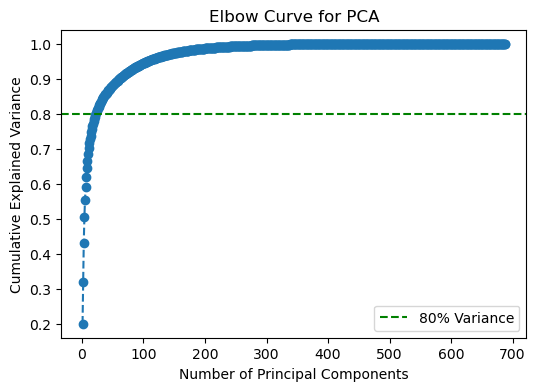

Number of components to explain 80% of variance: 23


In [ ]:
# PCA analysis to determine the number of components to explain 99% of variance

scaler = StandardScaler()
scaled = scaler.fit_transform(norm_signal_filtered)

pca = PCA()
pca.fit(scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components= np.argmax(cumulative_variance >= 0.8) +1



plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.8, color='g', linestyle='--', label="80% Variance")
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Curve for PCA')
plt.legend()
plt.show()

print(f"Number of components to explain 80% of variance: {n_components}")

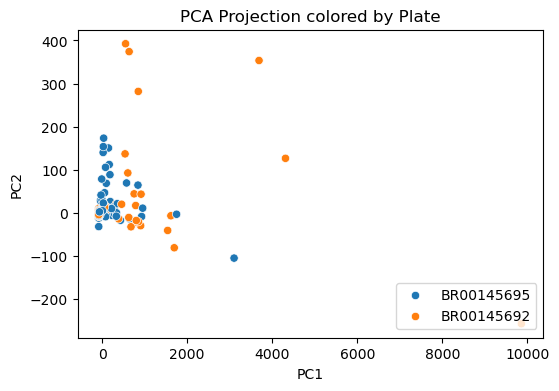

In [ ]:
## non scaled data PCA

pca = PCA(n_components)
principal_components = pca.fit_transform(norm_signal_filtered)

column_names = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(data=principal_components, columns=column_names)
pca_df.index = norm_signal_filtered.index 

pca_df['Plate'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_Plate']
pca_df['Compound'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_Compound Name']
pca_df['Concentration'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_assay_conc_uM']
pca_df= pca_df.sample(frac=1).reset_index(drop=True)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Plate'], palette="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Plate")
plt.legend(bbox_to_anchor=(0.67, 0.2), loc='upper left')
plt.show()

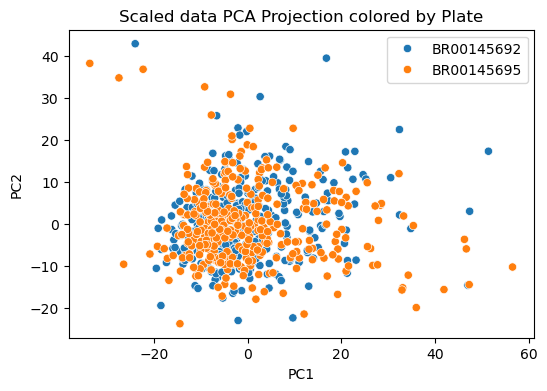

In [ ]:
## scaled data PCA

scaler = StandardScaler()
scaled = scaler.fit_transform(norm_signal_filtered)

pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled)


column_names = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(data=principal_components, columns=column_names, index=norm_signal_filtered.index)


pca_df['Plate'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_Plate']
pca_df['Compound'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_Compound Name']
pca_df['Concentration'] = norm_data.loc[norm_signal_filtered.index, 'Metadata_assay_conc_uM']

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Plate'], palette="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scaled data PCA Projection colored by Plate")
plt.legend(bbox_to_anchor=(0.67, 1), loc='upper left')
plt.show()

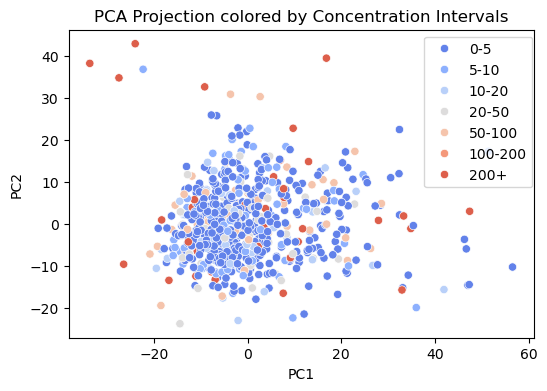

In [ ]:
##scaled data PCA colored by concentration intervals

bins = [0, 5, 10, 20, 50, 100, 200, 300] 
labels = ['0-5', '5-10', '10-20', '20-50', '50-100', '100-200', '200+']  


pca_df['Concentration_Binned'] = pd.cut(pca_df['Concentration'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Concentration_Binned'], palette="coolwarm")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Concentration Intervals")
plt.legend(bbox_to_anchor=(0.75, 1), loc='upper left')
plt.show()

['Compound' 'DMSO']


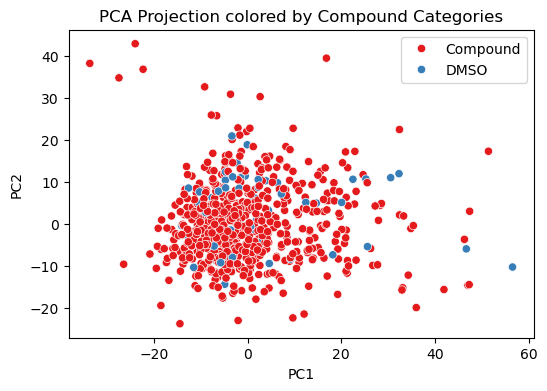

In [ ]:
# scaled data PCA by compound categories

pca_df['Category'] = pca_df['Compound'].apply(
    lambda x: 'DMSO' if x == 'DMSO' else ('Compound')
)


print(pca_df['Category'].unique())

plt.figure(figsize=(6, 4))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Category'], palette="Set1")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by Compound Categories")
plt.legend(bbox_to_anchor=(0.7, 1), loc='upper left')
plt.show()



0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_1744/2658235168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_data["UMAP1"], norm_data["UMAP2"] = umap_result[:, 0], umap_result[:, 1]
/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_1744/2658235168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

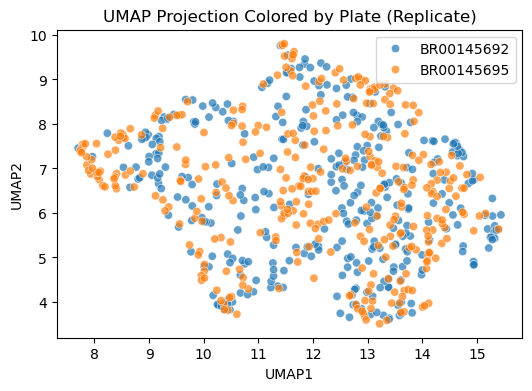

In [ ]:
# UMAP projection of the scaled data

umap_model = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(scaled)

norm_data["UMAP1"], norm_data["UMAP2"] = umap_result[:, 0], umap_result[:, 1]


metadata_color =  "Metadata_Plate"  #"Metadata_compound_concentration"  


plt.figure(figsize=(6, 4))
sns.scatterplot(
    x="UMAP1", y="UMAP2", hue=norm_data[metadata_color],    #style=norm_data["Metadata_BROAD_ID"],
    palette="tab10", data=norm_data, alpha=0.7 )
plt.title("UMAP Projection Colored by Plate (Replicate)")
plt.legend(bbox_to_anchor=(0.67, 1), loc='upper left')
plt.show()

### Scatterplots of replicates

In [ ]:
## the list of compound with unique concentration values + DMSO with 0uM concentration

single_concentration_compounds = norm_data.groupby('Metadata_Compound Name')['Metadata_assay_conc_uM'].nunique()
compounds_with_single_concentration = single_concentration_compounds[single_concentration_compounds == 1].index
filtered_data = norm_data[norm_data['Metadata_Compound Name'].isin(compounds_with_single_concentration)]

print(compounds_with_single_concentration)

Index(['AMG 900', 'Aloxistatin', 'DMSO', 'Dexamethasone (DHAP)', 'FK-866',
       'LY2109761', 'NVS-PAK1-1', 'Quinidine', 'TC-S 7004'],
      dtype='object', name='Metadata_Compound Name')


In [ ]:
## first 5 principal components tables, score per plate/replicate

num_pcs = 5  
pc_columns= [f"PC{i+1}" for i in range(num_pcs)]  


pca_pl = pl.DataFrame(pca_df)
pca_pl = pca_pl.filter(~pl.col("Compound").is_in(list(compounds_with_single_concentration)))

pca_melt = pca_pl.melt(
    id_vars=["Compound", "Concentration", "Plate"],
    value_vars=pc_columns,
    variable_name="PC",
    value_name="Score"
)

pc_tables = {}

for pc in pc_columns:
    globals()[pc.lower()] = pca_melt.filter(pl.col("PC") == pc).pivot(
        on="Plate",
        index=["Compound", "Concentration"],
        values="Score"
    ).to_pandas()

print(pc1.head())

        Compound  Concentration  BR00145692  BR00145695
0  Actinomycin D       300.0000   47.353026   33.284305
1  Actinomycin D       100.0000   22.883957   13.735376
2  Actinomycin D        33.3330   16.278714   -9.293294
3  Actinomycin D        11.1110  -19.443028    0.821910
4  Actinomycin D         3.7037  -15.904853   -1.204060


/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T/ipykernel_1744/2970861907.py:10: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  pca_melt = pca_pl.melt(


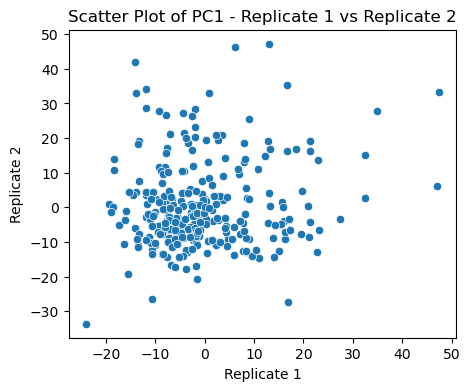

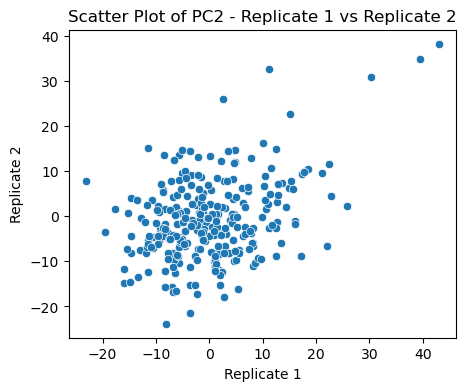

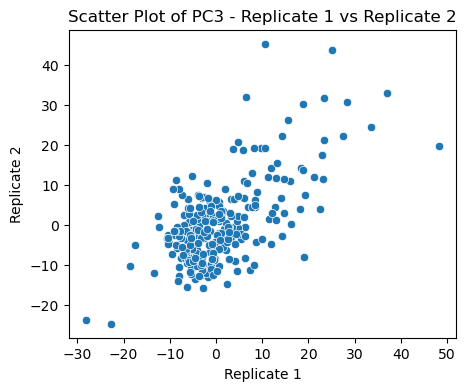

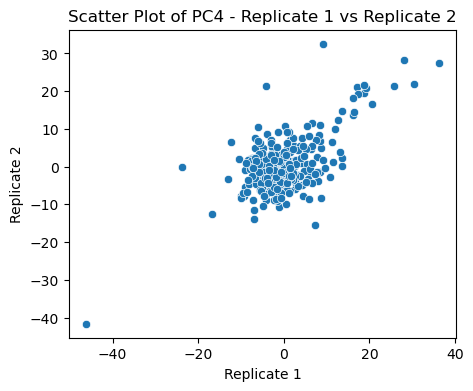

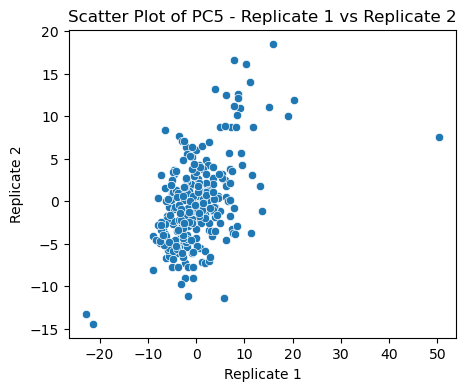

In [ ]:
def plot_scatter_plots(pc_df, pc_name):

    for plate1, plate2 in [('BR00145692', 'BR00145695')]: 
        if plate1 in pc_df.columns and plate2 in pc_df.columns:
            plt.figure(figsize=(5, 4))
            sns.scatterplot(x=pc_df[plate1], y=pc_df[plate2]) #, hue=pc_df['Concentration'], palette="tab10")
            plt.title(f"Scatter Plot of {pc_name} - Replicate 1 vs Replicate 2")
            plt.xlabel("Replicate 1")
            plt.ylabel("Replicate 2")
            #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()

pc_dataframes = [pc1, pc2, pc3, pc4, pc5]

for i, pc_df in enumerate(pc_dataframes, start=1):
    plot_scatter_plots(pc_df, f"PC{i}")


## plot the distribution of the features

df= norm_signal_filtered.copy()
batch_size = 20  
num_batches = len(df.columns) // batch_size + 1  

for batch in range(num_batches):
    features = df.columns[batch * batch_size : (batch + 1) * batch_size]
    
    plt.figure(figsize=(15, 10))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(4, 5, i) 
        sns.kdeplot(df[feature], fill=True, color="teal", alpha=0.6)
        plt.title(feature, fontsize=8)
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.show()

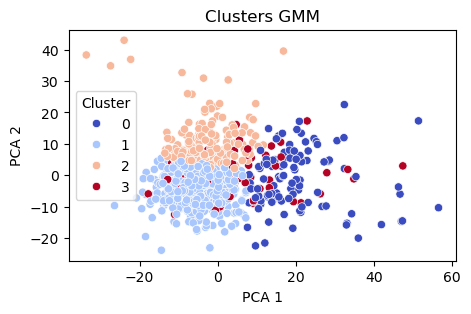

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=42)
df["Cluster_GMM"] = gmm.fit_predict(scaled)


plt.figure(figsize=(5,3))
sns.scatterplot(x=pca_df.iloc[:, 0], y=pca_df.iloc[:, 1], hue=df["Cluster_GMM"], palette="coolwarm")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters GMM")
plt.legend(title="Cluster")
plt.show()
